In [ ]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
!ln -s "/content/data/MyDrive/img/folder2"  "/content/data/MyDrive/img/test1/1"

ln: failed to create symbolic link '/content/data/MyDrive/img/test1/1/folder2': File exists


In [ ]:
!ls "/content/data/MyDrive/img/test1/1"

folder2


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
import math

image_size = 256
batch_size = 16

transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor() # ToTensor() changes the range of the values from [0, 255] to [0.0, 1.0]
])

cartoon_dataset = ImageFolder('/content/data/MyDrive/img/test1/', transformer)
len_training_set = math.floor(len(cartoon_dataset) * 0.9)
len_valid_set = len(cartoon_dataset) - len_training_set

training_set, _ = random_split(cartoon_dataset, (len_training_set, len_valid_set))
cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

In [ ]:
cartoon_image_dataloader_train
# for i in cartoon_image_dataloader_train:
#     print(i)
#     break

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


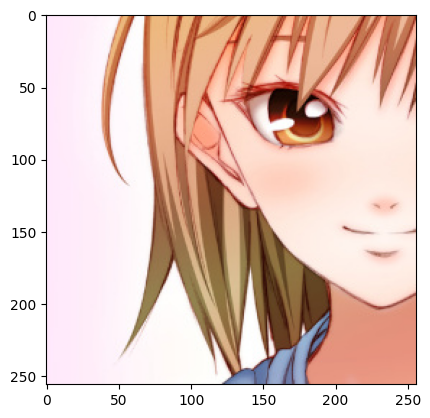

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_image(dataloader):
  iterator = iter(dataloader)
  sample_batch, _ = next(iterator)
  first_sample_image_of_batch = sample_batch[0]
  print(first_sample_image_of_batch.size())
  print("Current range: {} to {}".format(first_sample_image_of_batch.min(), first_sample_image_of_batch.max()))
  plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

show_sample_image(cartoon_image_dataloader_train)

In [ ]:
!git clone https://github.com/TobiasSunderdiek/cartoon-gan.git

Cloning into 'cartoon-gan'...
remote: Enumerating objects: 641, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 641 (delta 52), reused 47 (delta 17), pack-reused 541
Receiving objects: 100% (641/641), 12.48 MiB | 18.66 MiB/s, done.
Resolving deltas: 100% (315/315), done.


In [ ]:
%%writefile /content/cartoon-gan/cartoon_image_smoothing.py

import os
import cv2
from PIL import Image, ImageFilter
import downloader

PATH_TO_STORED_CARTOON_IMAGES = '/content/data/MyDrive/img/test1/1/folder2/'
PATH_TO_STORE_SMOOTHED_IMAGES = '/content/data/MyDrive/img/cartoongans_smoothed/'
SMOOTHED_IMAGES_ZIPFILE_NAME = '/content/data/MyDrive/img/cartoongans_smoothed'

def main():
    if not os.path.exists(PATH_TO_STORED_CARTOON_IMAGES):
        print("Can not smooth images, path does not exist: ", PATH_TO_STORED_CARTOON_IMAGES)

    if not os.path.exists(PATH_TO_STORE_SMOOTHED_IMAGES):
        os.makedirs(PATH_TO_STORE_SMOOTHED_IMAGES)

    for filename in os.listdir(PATH_TO_STORED_CARTOON_IMAGES):
        cartoon_images_filename = PATH_TO_STORED_CARTOON_IMAGES + filename
        smoothed_images_filename = PATH_TO_STORE_SMOOTHED_IMAGES + filename

        if not os.path.exists(smoothed_images_filename):
            edge_smoothing(cartoon_images_filename, smoothed_images_filename)
        else:
            print("Skipping file, already exists, ", cartoon_images_filename)

    downloader.zip_images(SMOOTHED_IMAGES_ZIPFILE_NAME, PATH_TO_STORE_SMOOTHED_IMAGES)

def edge_smoothing(cartoon_images_filename, smoothed_images_filename):
    print("Edge-smoothing of ", cartoon_images_filename)
    origin = cv2.imread(cartoon_images_filename)
    edges = createEdgesOverlay(origin)
    result = overlayEdges(edges, origin)
    result.save(smoothed_images_filename, "JPEG")

def overlayEdges(edges, origin):
    background = transformFromCV2ToPillowImageFormat(origin)
    background.paste(edges, (0, 0), edges)
    background = background.convert("RGB")
    return background

def transformFromCV2ToPillowImageFormat(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    return Image.fromarray(img)

def createEdgesOverlay(origin):
    edges = cv2.Canny(origin, 30, 300, 3)
    edges = cv2.dilate(edges, (3, 3))
    edges = cv2.bitwise_not(edges)
    edges = transformFromCV2ToPillowImageFormat(edges)
    makeWhiteBackgroundTransparent(edges)
    edges = edges.filter(ImageFilter.GaussianBlur) #do blurring here because doing it before making background transparent results in white halo

    return edges

# got this from here:
# https://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent/4531395
def makeWhiteBackgroundTransparent(img):
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)

if __name__ == '__main__':
    main()

Overwriting /content/cartoon-gan/cartoon_image_smoothing.py


In [ ]:
%cd cartoon-gan

/content/cartoon-gan


In [ ]:
!make cartoons-smooth

python cartoon_image_smoothing.py
Edge-smoothing of  /content/data/MyDrive/img/test1/1/folder2/imgsample_75d1ffca17628f730209f20545f59317778f3db1.jpg
Edge-smoothing of  /content/data/MyDrive/img/test1/1/folder2/imgsample_7ef3b0b4ec633f3a1131dcf0490fdb45a428ef3d.jpg
Edge-smoothing of  /content/data/MyDrive/img/test1/1/folder2/imgsample_a4cfc2c77f3c45a3eb3518bc8250ae368d10e7a5.jpg
Edge-smoothing of  /content/data/MyDrive/img/test1/1/folder2/imgsample_27ad65be8a904ae9bd709055345ab5fe3832c117.jpg
Edge-smoothing of  /content/data/MyDrive/img/test1/1/folder2/imgsample_d18249777b813b7957644943f57efe5cf1f89d84.jpg
Edge-smoothing of  /content/data/MyDrive/img/test1/1/folder2/imgsample_ce6e5dd411133ac96cf8bc43f907bac4e9019c5b.jpg
Edge-smoothing of  /content/data/MyDrive/img/test1/1/folder2/imgsample_c4cdb5eed27508336a0a523beba5ebd5a2e2d479.jpg
Edge-smoothing of  /content/data/MyDrive/img/test1/1/folder2/imgsample_eb4b69c6acc3f799048669a5ddd78d0d1e64d707.jpg
Edge-smoothing of  /content/data/MyDri